In [1]:
pip install torchaudio librosa scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [3]:
import librosa
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Загрузка нормальных звуков (например, работа двигателя)
normal_audio, sr = librosa.load("/content/sample-3s (1).wav", sr=16000)

# Создание мель-спектрограмм
def extract_features(audio, sr=16000, n_mels=64):
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    return librosa.power_to_db(mel)

normal_features = extract_features(normal_audio)

# Добавим искусственные аномалии (резкие звуки)
anomaly_audio = np.concatenate([normal_audio[:8000], 0.5 * np.random.randn(2000)])
anomaly_features = extract_features(anomaly_audio)

# Разделение на тренировочные и тестовые данные
X_train, X_test = train_test_split(normal_features.T, test_size=0.2, random_state=42)
X_anomaly = anomaly_features.T

# Преобразование в тензоры PyTorch
X_train = torch.FloatTensor(X_train).unsqueeze(1)  # [batch, 1, n_mels, time]
X_test = torch.FloatTensor(X_test).unsqueeze(1)
X_anomaly = torch.FloatTensor(X_anomaly).unsqueeze(1)

In [4]:
class AnomalyDetector(nn.Module):
    def __init__(self, input_dim=64):
        super().__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AnomalyDetector()

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Тренировка на нормальных звуках
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, X_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 44.4991
Epoch 10, Loss: 33.3901
Epoch 20, Loss: 26.5027
Epoch 30, Loss: 21.8647
Epoch 40, Loss: 18.0860
Epoch 50, Loss: 15.5216
Epoch 60, Loss: 13.6928
Epoch 70, Loss: 12.1130
Epoch 80, Loss: 10.8115
Epoch 90, Loss: 9.6495


In [14]:
# Функция для вычисления ошибки реконструкции
def detect_anomalies(model, X, threshold=0.1):
    with torch.no_grad():
        reconstructions = model(X)
        errors = torch.mean((X - reconstructions)**2, dim=(1,2))
        anomalies = errors > threshold
    return anomalies.numpy(), errors.numpy()

# Тестирование на нормальных и аномальных звуках
normal_preds, normal_errors = detect_anomalies(model, X_test)
anomaly_preds, anomaly_errors = detect_anomalies(model, X_anomaly)

print(f"Normal errors: mean={normal_errors.mean():.4f}")
print(f"Anomaly errors: mean={anomaly_errors.mean():.4f}")

Normal errors: mean=8.0690
Anomaly errors: mean=10.9711


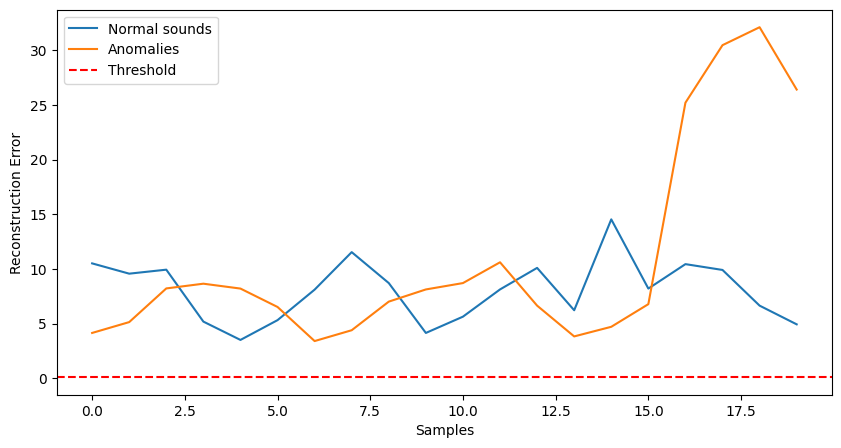

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(normal_errors, label='Normal sounds')
plt.plot(anomaly_errors, label='Anomalies')
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()